# Guides to LiDAR (Part 5 - Extract building footprints from classified LiDAR)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Step-1.-Convert-LiDAR-to-raster" data-toc-modified-id="Step-1.-Convert-LiDAR-to-raster-1">Step 1. Convert LiDAR to raster</a></span></li><li><span><a href="#Step-2.-Create-Mosaic-Dataset" data-toc-modified-id="Step-2.-Create-Mosaic-Dataset-2">Step 2. Create Mosaic Dataset</a></span></li><li><span><a href="#Step-3.-Replace-Mosaic-Dataset-Raster-Function-Template" data-toc-modified-id="Step-3.-Replace-Mosaic-Dataset-Raster-Function-Template-3">Step 3. Replace Mosaic Dataset Raster Function Template</a></span></li><li><span><a href="#Step-4.-Extract-Draft-Building-Footprint-Polygons" data-toc-modified-id="Step-4.-Extract-Draft-Building-Footprint-Polygons-4">Step 4. Extract Draft Building Footprint Polygons</a></span></li><li><span><a href="#Step-5.-Regularize-Draft-Building-Footprint-Polygons" data-toc-modified-id="Step-5.-Regularize-Draft-Building-Footprint-Polygons-5">Step 5. Regularize Draft Building Footprint Polygons</a></span><ul class="toc-item"><li><span><a href="#5.1-Divide-polygons" data-toc-modified-id="5.1-Divide-polygons-5.1">5.1 Divide polygons</a></span><ul class="toc-item"><li><span><a href="#5.1.1-Subset-of-large-sized-buildings" data-toc-modified-id="5.1.1-Subset-of-large-sized-buildings-5.1.1">5.1.1 Subset of large-sized buildings</a></span></li><li><span><a href="#5.1.2-Subset-of-medium-sized-buildings" data-toc-modified-id="5.1.2-Subset-of-medium-sized-buildings-5.1.2">5.1.2 Subset of medium-sized buildings</a></span></li><li><span><a href="#5.1.3-Subset-of-small-sized-buildings" data-toc-modified-id="5.1.3-Subset-of-small-sized-buildings-5.1.3">5.1.3 Subset of small-sized buildings</a></span></li></ul></li><li><span><a href="#5.2-Find-Circle-Buildings" data-toc-modified-id="5.2-Find-Circle-Buildings-5.2">5.2 Find Circle Buildings</a></span></li><li><span><a href="#5.3-Regularize-Building-Footprint" data-toc-modified-id="5.3-Regularize-Building-Footprint-5.3">5.3 Regularize Building Footprint</a></span><ul class="toc-item"><li><span><a href="#5.3.1-For-large-sized-buildings" data-toc-modified-id="5.3.1-For-large-sized-buildings-5.3.1">5.3.1 For large-sized buildings</a></span></li><li><span><a href="#5.3.2--For-the-medium-sized-buildings" data-toc-modified-id="5.3.2--For-the-medium-sized-buildings-5.3.2">5.3.2  For the medium-sized buildings</a></span></li><li><span><a href="#5.3.3-For-the-small-sized-buildings" data-toc-modified-id="5.3.3-For-the-small-sized-buildings-5.3.3">5.3.3 For the small-sized buildings</a></span></li></ul></li><li><span><a href="#5.4-Generalize-Buildings" data-toc-modified-id="5.4-Generalize-Buildings-5.4">5.4 Generalize Buildings</a></span></li><li><span><a href="#5.5-Validation" data-toc-modified-id="5.5-Validation-5.5">5.5 Validation</a></span><ul class="toc-item"><li><span><a href="#5.5.1-Building-raster-V.S.-Generalized-building" data-toc-modified-id="5.5.1-Building-raster-V.S.-Generalized-building-5.5.1">5.5.1 Building raster V.S. Generalized building</a></span></li><li><span><a href="#5.5.2-Imagery-basemap-V.S.-Generalized-building" data-toc-modified-id="5.5.2-Imagery-basemap-V.S.-Generalized-building-5.5.2">5.5.2 Imagery basemap V.S. Generalized building</a></span></li><li><span><a href="#5.5.3-Original-LiDAR-point-clouds-V.S.-Generalized-building" data-toc-modified-id="5.5.3-Original-LiDAR-point-clouds-V.S.-Generalized-building-5.5.3">5.5.3 Original LiDAR point clouds V.S. Generalized building</a></span></li></ul></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-6">Conclusions</a></span></li><li><span><a href="#References" data-toc-modified-id="References-7">References</a></span></li></ul></div>

Parts 5 and 6 are to demonstrate the workflows to create building footprints from LiDAR data, classified and unclassified respectively. The general workflow to accommodate both LiDAR sources (classified for buildings, and the unclassified) is the same, and would do the following:

  - Convert LiDAR to rasters
  - Create mosaic datasets to manage the rasters
  - Apply function chains to the mosaic datasets
  - Convert the footprints to polygons
  - Clean the polygons with tools

At the end of both notebooks (Parts 5 and 6), an additional step to validate the result is there to show the hits and misses of the buildings. We can see that no result can be perfect but, for quick building extraction with some clean up, this workflow works well. First, let's start with the LiDAR with classifications.

## Step 1. Convert LiDAR to raster

This step is to create a folder containing a raster with pixels classified as buildings.

In [ ]:
import arcpy
import os
import time
arcpy.env.overwriteOutput = True

In [ ]:
# where you store the input las files
in_folder = r"<Root Folder>\3DMappingWithLidarPointClouds\3DMappingWorkshop_IMF2017\20140406_sandy_usgs_de_1986"
# where you output the intermediate output
scratch_folder = r"<Root Folder>\3DMappingWithLidarPointClouds\3DMappingWorkshop_IMF2017\Output"
# where you download the RFTs
rft_folder = r"<Root Folder>\3DMappingWithLidarPointClouds\3DMappingWorkshop_IMF2017\ExtractClassifiedForBuildings\.idea"
# where the feature class is output into
gdb_location = r"<Root Folder>\3DMappingWithLidarPointClouds\3DMappingWorkshop_IMF2017\Output\ClassifiedBuildingMosaics.gdb"

Usually one Las Dataset contains more than one Las files, and here we will define a function `recursive_process` to help iterate all Las files included in the input folder, and create/add to the Las Dataset.

In [ ]:
def recursive_process(tile_list, count, spatial_ref, cell_size, scratch_folder):
    """# Purpose:     Process for extracting Building Raster Tiles from Classified LiDAR
       # Authors:     G. Taylor，A. Crawford，& A. Watson
       # Copyright:   @Esri
    """
    # Check to ensure that scratch folder exists:
    if not os.path.exists(scratch_folder):
        os.makedirs(scratch_folder)
    bldgPt_rasters = os.path.join(scratch_folder, "bldgPt_rasters")
    if not os.path.exists(bldgPt_rasters):
        os.makedirs(bldgPt_rasters)
    
    # Recursively process LiDAR Tiles
    iteration = 0
    arcpy.SetProgressor("step", "Percent Complete...", 0, count, iteration)
    for file in tile_list:
        try:
            arcpy.SetProgressor("step", "{0} Percent Complete...".format(round((100/count)*iteration, 1)), 
                                0, count, iteration)
            full_file_name = os.path.join(in_folder, file)
            print(full_file_name)
            
            # Obtain file name without extension and add .las:
            file_name = "{0}".format(os.path.splitext(file)[0])
            # Create Las Dataset Layers in scratch folder
            in_LASD = os.path.join(scratch_folder, "{0}.lasd".format(os.path.splitext(file)[0]))
            print(in_LASD)
            
            arcpy.CreateLasDataset_management(input = full_file_name, 
                                              out_las_dataset = in_LASD, 
                                              folder_recursion = False, 
                                              in_surface_constraints = "", 
                                              spatial_reference = spatial_ref, 
                                              compute_stats = "COMPUTE_STATS")
            
            arcpy.MakeLasDatasetLayer_management(in_las_dataset = in_LASD, 
                                                 out_layer= file_name, 
                                                 class_code = 6,
                                                 return_values = "'Last Return'",
                                                 no_flag = "INCLUDE_UNFLAGGED", 
                                                 synthetic = "INCLUDE_SYNTHETIC", 
                                                 keypoint = "INCLUDE_KEYPOINT",
                                                 withheld = "EXCLUDE_WITHHELD", 
                                                 surface_constraints = None, 
                                                 overlap = "INCLUDE_OVERLAP")
            
            bldgPt_raster = os.path.join(bldgPt_rasters, "{0}.tif".format(os.path.splitext(file)[0]))
            
            arcpy.LasPointStatsAsRaster_management(in_las_dataset = file_name, 
                                                   out_raster = bldgPt_raster, 
                                                   method = "PREDOMINANT_CLASS", 
                                                   sampling_type = "CELLSIZE", 
                                                   sampling_value = cell_size)

            # Delete Intermediate Data
            arcpy.Delete_management(file_name)
            arcpy.Delete_management(in_LASD)
            iteration = iteration + 1
            arcpy.SetProgressorPosition()
        except:
            # TODO Geof7015 Log pass/fail at later date
            iteration = iteration + 1
            arcpy.SetProgressorPosition()
            errorMessage = "{0} failed @ {1} : Check if building class-codes exist".format(file, time.strftime("%H:%M:%S"))
            arcpy.AddMessage(errorMessage)
            #logMessage(logFile, errorMessage)
            in_LASD = os.path.join(scratch_folder, "{0}.lasd".format(os.path.splitext(file)[0]))
            if arcpy.Exists(in_LASD):
                arcpy.Delete_management(in_LASD)
            pass

Next, we will define another function `LiDAR_to_raster_tiles` which can convert the LiDAR dataset into raster tiles, and it will take advantages of some arcpy functions dedicated for Las Dataset. Syntaxes for these arcpy tools being used are listed below:

```
CreateLasDataset_management (input, out_las_dataset, {folder_recursion}, {in_surface_constraints}, {spatial_reference}, {compute_stats}, {relative_paths})
```
For more info with `CreateLasDataset_management`, please check the <a href="https://desktop.arcgis.com/en/arcmap/10.3/tools/data-management-toolbox/create-las-dataset.htm#C_GUID-7451F211-DA23-47AE-B300-5D394901CD3F">help doc</a>, and
```
MakeLasDatasetLayer(in_las_dataset, out_layer, {class_code}, {return_values}, {no_flag}, {synthetic}, {keypoint}, {withheld}, {surface_constraints}, {overlap})
```
in which the `class_code` can be selected from these numbers:

  - 0 —Never processed by a classification method.
  - 1 —Processed by a classification method but could not be determined
  - 2 —Bare earth measurements
  - 3 —Vegetation whose height is considered to be low for the area
  - 4 —Vegetation whose height is considered to be intermediate for the area
  - 5 —Vegetation whose height is considered to be high for the area
  - 6 —Structure with roof and walls
  - 7 —Erroneous or undesirable data that is closer to the ground

For more info, please check the <a href="https://pro.arcgis.com/en/pro-app/tool-reference/data-management/make-las-dataset-layer.htm">help doc</a>, and also
```
LasPointStatsAsRaster(in_las_dataset, out_raster, {method}, {sampling_type}, {sampling_value})
```
in which `method` can be chosen from these strings:

  - PULSE_COUNT —The number of last return points.
  - POINT_COUNT —The number of points from all returns.
  - PREDOMINANT_LAST_RETURN —The most frequent last return value.
  - PREDOMINANT_CLASS —The most frequent class code.
  - INTENSITY_RANGE —The range of intensity values.
  - Z_RANGE —The range of elevation values.

In [3]:
def LiDAR_to_raster_tiles(in_folder, scratch_folder, spatial_ref, cell_size):
    # Obtain LiDAR tile Info from Folder
    lasCount = 0
    lasList = []
    zlasCount = 0
    zlasList = []
    for file in os.listdir(in_folder):
        if file.endswith('.zlas'):
            zlasCount = zlasCount + 1
            zlasList.append(file)
            #print(file)
        if file.endswith('.las'):
            lasCount = lasCount + 1
            lasList.append(file)
            #print(file)

    # Check that LiDAR tiles exist in folder directory location
    arcpy.SetProgressor("step", "Processing Tiles...", 0, zlasCount, 1)
    if lasCount == 0 and zlasCount == 0:
        print("Cancelling Process as 0 LAS of zLAS tiles detected")
        exit()
    if lasCount > 0 and zlasCount > 0:
        print("Cancelling Process as {0} zLAS and {1} LAS files detected in process".format(zlasCount, lasCount))
        exit()
    if lasCount == 0 and zlasCount > 0:
        arcpy.AddMessage("{0} zLAS Tiles Detected for Processing".format(zlasCount))
        recursive_process(tile_list=zlasList, count=zlasCount, spatial_ref=spatial_ref, 
                          cell_size=cell_size, scratch_folder=scratch_folder)
    if lasCount > 0 and zlasCount == 0:
        arcpy.AddMessage("{0} LAS Tiles Detected for Processing".format(lasCount))
        recursive_process(tile_list=lasList, count=lasCount, spatial_ref=spatial_ref, 
                         cell_size=cell_size, scratch_folder=scratch_folder)
    arcpy.AddMessage("Process Complete")
    exit()

In [ ]:
spatial_ref_str = "PROJCS['NAD_1983_StatePlane_Delaware_FIPS_0700_Feet',GEOGCS['GCS_North_American_1983',DATUM['D_North_American_1983',SPHEROID['GRS_1980',6378137.0,298.257222101]],PRIMEM['Greenwich',0.0],UNIT['Degree',0.0174532925199433]],PROJECTION['Transverse_Mercator'],PARAMETER['False_Easting',656166.6666666665],PARAMETER['False_Northing',0.0],PARAMETER['Central_Meridian',-75.41666666666667],PARAMETER['Scale_Factor',0.999995],PARAMETER['Latitude_Of_Origin',38.0],UNIT['Foot_US',0.3048006096012192]];-17792300 -46619000 3048.00609601219;-100000 10000;-100000 10000;3.28083333333333E-03;0.001;0.001;IsHighPrecision"

With the function defined, and the input parameters declared above, we are now ready to call the `LiDAR_to_raster_tiles` here:

In [ ]:
LiDAR_to_raster_tiles(in_folder, scratch_folder, spatial_ref_str, 2)

## Step 2. Create Mosaic Dataset

Previously in step 1, `LiDAR_to_raster_tiles` outputs the raster format of buildings into the `bldgPt_rasters` directory inside the scratch folder, which is to be used as input parameter here.

In [ ]:
raster_folder = r"<Root>\3DMappingWithLidarPointClouds\3DMappingWorkshop_IMF2017\Output\bldgPt_rasters"

Step 2 is to create a mosaic dataset from the tiled rasters (generated in step 1) and add to display. The arcpy tools `CreateMosaicDataset_management` and `AddRastersToMosaicDataset_management` in the Mosaic Dataset Toolset will be used in the function defined below:

In [ ]:
def tiles_to_mosaic_dataset2(in_raster_folder, out_folder, gdb_name, spatial_ref):
    mosaic_name = 'BuildingRaster'

    # Check gdb name and delete if exists
    if not gdb_name.endswith('.gdb'):
        gdb_name = '{}.gdb'.format(gdb_name)
    gdb = os.path.join(out_folder, gdb_name)
    if arcpy.Exists(gdb):
        arcpy.Delete_management(gdb)
    arcpy.CreateFileGDB_management(out_folder, gdb_name, "CURRENT")
    arcpy.AddMessage('Geodatabase {} creatred...'.format(gdb_name))

    # Create an empty mosaic dataset in a geodatabase
    arcpy.CreateMosaicDataset_management(in_workspace = gdb, 
                                         in_mosaicdataset_name = mosaic_name, 
                                         coordinate_system = spatial_ref, 
                                         num_bands = None, 
                                         pixel_type = "8_BIT_UNSIGNED", 
                                         product_definition = "CUSTOM", 
                                         product_band_definitions = None)
    mosaic_DS = os.path.join(gdb, mosaic_name)
    arcpy.AddMessage('Mosaic dataset {} created...'.format(mosaic_name))

    # Add rasters to mosaic from a folder, and set cell size
    arcpy.AddMessage('Adding rasters to mosaic dataset...')
    arcpy.AddRastersToMosaicDataset_management(in_mosaic_dataset = mosaic_DS, 
                                               raster_type = "Raster Dataset", 
                                               input_path = in_raster_folder,
                                               update_cellsize_ranges = "UPDATE_CELL_SIZES", 
                                               update_boundary = "UPDATE_BOUNDARY", 
                                               update_overviews = "NO_OVERVIEWS", 
                                               maximum_pyramid_levels = None, 
                                               maximum_cell_size = 0, 
                                               minimum_dimension = 1500,
                                               spatial_reference = None, 
                                               filter = None, 
                                               sub_folder = "SUBFOLDERS", 
                                               duplicate_items_action = "ALLOW_DUPLICATES", 
                                               build_pyramids = "NO_PYRAMIDS", 
                                               calculate_statistics = "NO_STATISTICS",
                                               build_thumbnails = "NO_THUMBNAILS", 
                                               operation_description = None, 
                                               force_spatial_reference = "NO_FORCE_SPATIAL_REFERENCE", 
                                               estimate_statistics = "NO_STATISTICS", 
                                               aux_inputs = None)

    # Update mosaic cell size
    arcpy.AddMessage('Updating mosaic cell size...')
    cell_size = arcpy.GetRasterProperties_management(mosaic_DS, "CELLSIZEX")
    new_size = float(float(cell_size.getOutput(0))/2)
    arcpy.SetMosaicDatasetProperties_management(mosaic_DS, cell_size= new_size)

    arcpy.AddMessage("Process complete")

In [ ]:
tiles_to_mosaic_dataset2(in_raster_folder = raster_folder, 
                         out_folder = scratch_folder, 
                         gdb_name = "ClassifiedBuildingMosaics", 
                         spatial_ref = spatial_ref_str)

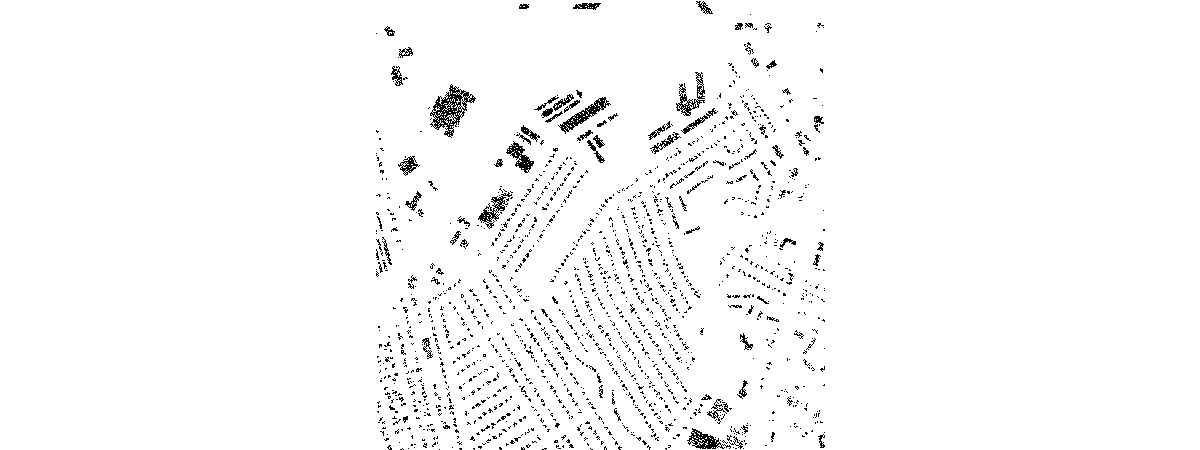

In [1]:
from arcgis.raster import ImageryLayer
bldg_raster_img_lyr = ImageryLayer(url="https://your.enterprise.org/server/rest/services/Image_Layer_BuildingRaster/ImageServer")
bldg_raster_img_lyr

## Step 3. Replace Mosaic Dataset Raster Function Template

A `raster function template` (RFT) can be created to fill Void or NoData areas in an elevation raster using a combination of plane fitting and Inverse Distance Weighting (IDW) methods. Based on the number of times that smoothing has been executed, the filter type (low-pass/high-pass), and the window size, we created different levels of smoothing RFTs, e.g. `0 No Smoothing`, `1 Smooth`, etc.

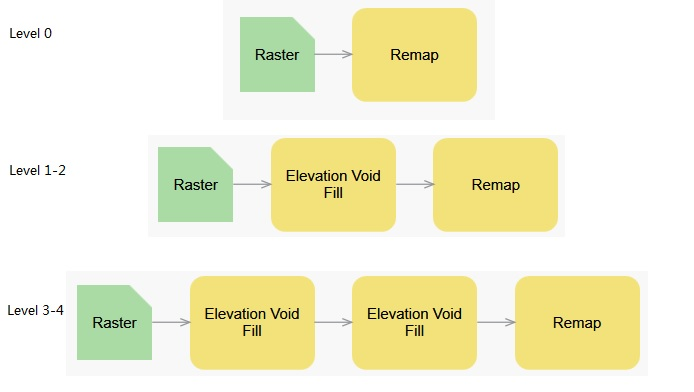
Fig 1. Levels of Smoothing.

Before we apply a function chain to the mosaic dataset in order to fill in areas between the pixels, let's first access the raster function template file (1 Smooth.rft.xml), and download into a local directory:

In [4]:
from arcgis.gis import GIS
gis = GIS("https://pythonapi.playground.esri.com/portal")

In [5]:
item = gis.content.get("5e82106af6974cdb8106fe7349e34b99")
item

<Item title:"1 Smooth RFT" type:Raster function template owner:api_data_owner>

In [3]:
# Check to ensure that download folder exists:
if not os.path.exists(rft_folder):
    os.makedirs(rft_folder)
# download the RFT item into local folder
item.download(save_path=rft_folder)

Then to define a customized function `replace_raster_function_template`, and apply it onto the mosaic dataset as to replace the raster function template e.g. `0 No Smoothing.rft.xml` with `1 Smooth.rft.xml`:

In [ ]:
def replace_raster_function_template(mosaic_name, raster_function_name):
    
    desc = arcpy.Describe(mosaic_name)
    if hasattr(desc, "layer"):
        mosaic_DS = desc.layer.catalogPath
    else:
        mosaic_DS = desc.catalogPath

    raster_function = os.path.join(rft_folder, '{}.rft.xml'.format(raster_function_name))

    # Replace the function
    arcpy.AddMessage('Replacing raster function template...')
    arcpy.EditRasterFunction_management(mosaic_DS, "EDIT_MOSAIC_DATASET", "REPLACE", raster_function, '#')

    arcpy.AddMessage('Replacement complete')

In [ ]:
replace_raster_function_template("BuildingRaster", "1 Smooth")

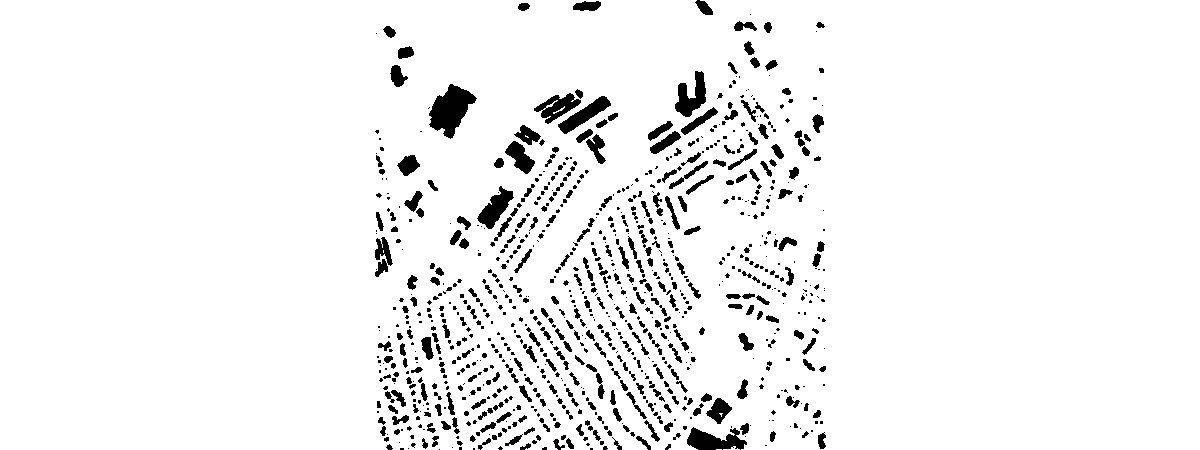

In [2]:
bldg_raster_img_lyr = ImageryLayer(url="https://your.enterprise.org/server/rest/services/Image_Layer_BuildingRaster_Smooth/ImageServer")
bldg_raster_img_lyr

## Step 4. Extract Draft Building Footprint Polygons

In Step 4, we will need to generate polygons from the raster, with the gp tool `Raster To Polygon`<a href="#References">[1]</a>.

Before extracting the building footprints, the raster image of buildings (shown as an overlay on top of the satellite image) looks like the figure below.

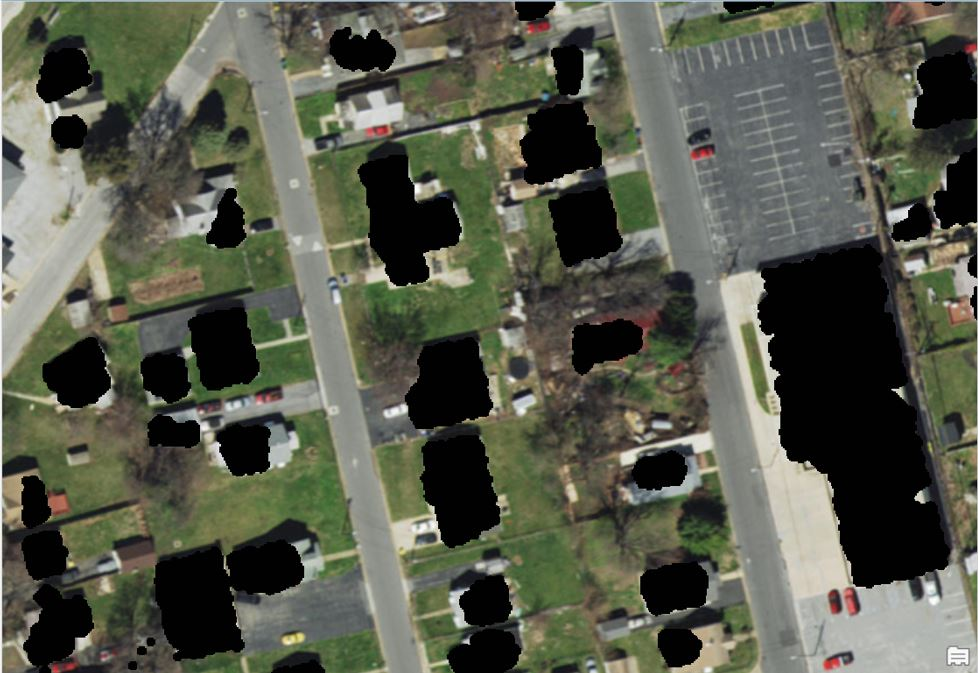
Fig 2. Before extracting the footprints.

In [ ]:
from sys import argv

# 4) Extract Draft Building Footprint Polygons
def model(input_raster, output_polygon_features):  

    # To allow overwriting outputs change overwriteOutput option to True.
    arcpy.env.overwriteOutput = False

    simplify_polygons = False

    # Process: Raster to Polygon (Raster to Polygon) 
    arcpy.RasterToPolygon_conversion(in_raster=input_raster, 
                                     out_polygon_features=output_polygon_features, 
                                     simplify=simplify_polygons, 
                                     raster_field="", 
                                     create_multipart_features="SINGLE_OUTER_PART", 
                                     max_vertices_per_feature=None)

In [ ]:
model(input_raster = r"BuildingRaster\Image", 
      output_polygon_features = os.path.join(gdb_location, "DraftPolygons"))

After `Raster to polygon` conversion, the buildings footprint (which is saved as `DraftPolygons` feature class in the local file gdb) looks like the figure below.

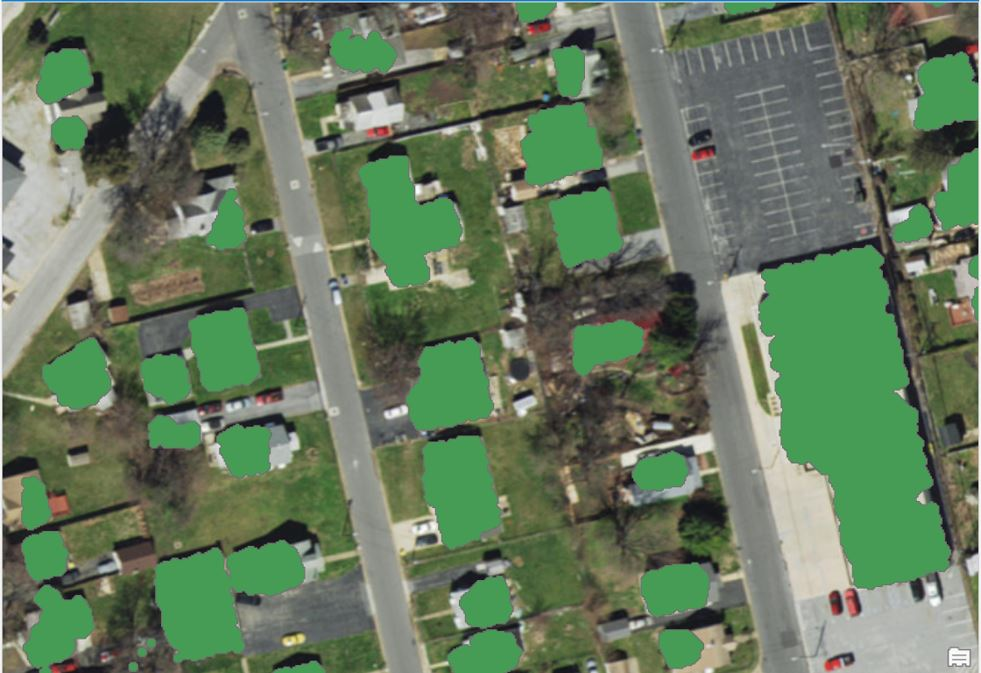
Fig 3. The satellite image, with overlay of buildings footprint being created by `Raster to polygon` tool.

## Step 5. Regularize Draft Building Footprint Polygons

Step 5 itself is a complex workflow which includes dividing building polygons to small, medium, and large polygons, finding circle buildings, regularizing and generalizing buildings, and at the end performing validation. The reason to divide the input building polygons into different classes, perform all other operations, and merging these three classes of output into one feature class, is to tailor the criteria of each class (e.g. polygon area, lengths, shapes), and reduce the errors at processing.

### 5.1 Divide polygons  

First, we need to divide the polygons into small, medium and large polygons to process differently. The `Minimum Size of Polygons` in `Square Feet` parameter is pre-set to 250, which is equivalent to 23 square meters (which is roughly a 15ft x 15ft building). If the LiDAR data source being provided could support smaller buildings, you could set a lower `Minimum Size`.

The tool `Regularize Building Footprint` used here is to normalize the footprint of building polygons by eliminating undesirable artifacts in their geometry, utilizing a `polyline compression algorithm` tool to correct distortions in building footprint polygons created through feature extraction workflows that may produce undesirable artifacts <a href="#References">[2]</a>.

In [ ]:
input2_2_ = os.path.join(gdb_location, "DraftPolygons")
workspace = gdb_location

#### 5.1.1 Subset of large-sized buildings

In [ ]:
# Parameters
large_definition = "\"POLY_AREA\" > 8000"
large_method = "RIGHT_ANGLES_AND_DIAGONALS"
large_tolerance = 8
large_densification = 4
large_precision = 0.25
large_diagonal_penalty = 1.5

In [ ]:
# large polygons
# Process: Make Feature Layer (3) (Make Feature Layer) 
circle8 = "input_Layer2"
arcpy.MakeFeatureLayer_management(in_features=input2_2_, 
                                  out_layer=circle8, 
                                  where_clause=large_definition, 
                                  workspace="", 
                                  field_info="OBJECTID OBJECTID VISIBLE NONE;\
                                  Shape Shape VISIBLE NONE;Id Id VISIBLE NONE;\
                                  gridcode gridcode VISIBLE NONE;Shape_Length Shape_Length VISIBLE NONE;\
                                  Shape_Area Shape_Area VISIBLE NONE;POLY_AREA POLY_AREA VISIBLE NONE;\
                                  Type Type VISIBLE NONE;Process Process VISIBLE NONE")

# Process: Regularize Building Footprint (2) (Regularize Building Footprint) 
circle8_2_ = fr"{workspace}\Circle8"
with arcpy.EnvManager(extent="DEFAULT"):
    arcpy.RegularizeBuildingFootprint_3d(in_features=circle8, 
                                         out_feature_class=circle8_2_, 
                                         method="CIRCLE", tolerance=large_tolerance, 
                                         densification=None, precision=large_precision, 
                                         diagonal_penalty=large_diagonal_penalty, 
                                         min_radius=0.1, max_radius=1000000)

#### 5.1.2 Subset of medium-sized buildings

In [ ]:
# Parameters
medium_definition = "\"POLY_AREA\" > 3000 AND \"POLY_AREA\" <= 8000"
medium_method = "RIGHT_ANGLES_AND_DIAGONALS"
medium_tolerance = 5
medium_densification = 3
medium_precision = 0.25
medium_diagonal_penalty = 1.5

In [ ]:
# Medium polygons
# Process: Make Feature Layer (5) (Make Feature Layer) 
circle5 = "input_Layer3"
arcpy.MakeFeatureLayer_management(in_features=input2_2_, 
                                  out_layer=circle5, 
                                  where_clause=medium_definition, 
                                  workspace="", 
                                  field_info="OBJECTID OBJECTID VISIBLE NONE;\
                                  Shape Shape VISIBLE NONE;Id Id VISIBLE NONE;\
                                  gridcode gridcode VISIBLE NONE;Shape_Length Shape_Length VISIBLE NONE;\
                                  Shape_Area Shape_Area VISIBLE NONE;POLY_AREA POLY_AREA VISIBLE NONE;\
                                  Type Type VISIBLE NONE;Process Process VISIBLE NONE")

# Process: Regularize Building Footprint (4) (Regularize Building Footprint) 
circle5_3_ = fr"{workspace}\Circle5"
with arcpy.EnvManager(extent="DEFAULT"):
    arcpy.RegularizeBuildingFootprint_3d(in_features=circle5, 
                                         out_feature_class=Ccircle5_3_, 
                                         method="CIRCLE", tolerance=medium_tolerance, 
                                         densification=None, precision=medium_precision, 
                                         diagonal_penalty=medium_diagonal_penalty, 
                                         min_radius=0.1, max_radius=1000000)

#### 5.1.3 Subset of small-sized buildings

In [ ]:
# Parameters
small_definition = "\"POLY_AREA\" > 250 AND \"POLY_AREA\" <= 3000"
small_method = "RIGHT_ANGLES"
small_tolerance = 2
small_densification = 2
small_precision = 0.25
small_diagonal_penalty = 1.5

In [ ]:
# small polygons
# Process: Make Feature Layer (5) (Make Feature Layer) 
circle2 = "input_Layer6"
arcpy.MakeFeatureLayer_management(in_features=input2_2_, 
                                  out_layer=circle2, 
                                  where_clause=small_definition, 
                                  workspace="", field_info="OBJECTID OBJECTID VISIBLE NONE;\
                                  Shape Shape VISIBLE NONE;Id Id VISIBLE NONE;\
                                  gridcode gridcode VISIBLE NONE;Shape_Length Shape_Length VISIBLE NONE;\
                                  Shape_Area Shape_Area VISIBLE NONE;POLY_AREA POLY_AREA VISIBLE NONE;\
                                  Type Type VISIBLE NONE;Process Process VISIBLE NONE")

# Process: Regularize Building Footprint (4) (Regularize Building Footprint) 
circle2_6_ = fr"{workspace}\Circle2"
with arcpy.EnvManager(extent="DEFAULT"):
    arcpy.RegularizeBuildingFootprint_3d(in_features=circle2, 
                                         out_feature_class=circle2_6_, 
                                         method="CIRCLE", tolerance=small_tolerance, 
                                         densification=None, precision=small_precision, 
                                         diagonal_penalty=small_diagonal_penalty, 
                                         min_radius=0.1, max_radius=1000000)

This `RegularizeBuildingFootprint_3d` tool calculates a `compactness ratio` in identifying circular buildings, using the following formula:

$$\!Compactness  Ratio\! = \frac{4 * \Pi * \!shape.area\!}{(\!shape.length\!) ^ 2}$$

A perfect circle will have a value of 1, but since the polygons typically processed with this tool have some irregularity, values closer to 1 are more likely to have a circular shape <a href="#References">[2]</a>. 

Also, a new column is created and added to the output feature class - `STATUS`. When the specified parameters cannot produce a regularized solution for a given input, the original feature is copied to the output. The value specified in the STATUS field will indicate whether the feature was regularized or not: 
  - 0 - original feature; 
  - non-zero, regularized feature.

In [ ]:
# Process: Merge
circle_merg = fr"{workspace}\CircleMerg"
with arcpy.EnvManager(extent="MAXOF"):
    arcpy.Merge_management(inputs=[circle8_2_, circle5_3_, circle2_6_],
                           output = circle_merg,
                           field_mappings=fr"Id \"Id\" true true false 4 Long 0 0,First,#,{workspace}\circle8,\
                                             Id,-1,-1,{workspace}\circle5,\
                                             Id,-1,-1,{workspace}\circle2,STATUS,-1,-1",
                           add_source = "NO_SOURCE_INFO")

### 5.2 Find Circle Buildings

Also we need to find possible Circle Buildings (tanks, for the majority). Usually, we need to review `CircleBuildings` to find ones that are real and delete others. This step takes advantage of the `STATUS` field being generated previously, in classifying which features are circle buildings - if status is zero, then that feature failed to be regularized, and less likely to be a building structure. 

Note that, we are not yet to remove the potential circle buildings from the merged layer easily - since there might be some missed matches. Let's keep the circle buildings, until later when we have a generalized result of buildings (in section 5.4) then we can delete the feature(s) in `Building_generalized` which are coincident with `CircleBuildings`.

In [ ]:
# Process: Make Feature Layer (Make Feature Layer) 
circle_merg_layer = fr"{workspace}\CircleMerg_Layer"
arcpy.MakeFeatureLayer_management(in_features=circle_merg, 
                                  out_layer=circle_merg_layer, 
                                  where_clause="\"STATUS\" = 0", 
                                  workspace="", 
                                  field_info="Shape_Leng Shape_Leng VISIBLE NONE;POLY_AREA POLY_AREA VISIBLE NONE;\
                                  Type Type VISIBLE NONE;Process Process VISIBLE NONE;\
                                  Shape_Length Shape_Length VISIBLE NONE;Shape_Area Shape_Area VISIBLE NONE;\
                                  ORIG_OID ORIG_OID VISIBLE NONE;STATUS STATUS VISIBLE NONE;Id Id VISIBLE NONE;\
                                  gridcode gridcode VISIBLE NONE")

# Process: Add Geometry Attributes (2) (Add Geometry Attributes) 
circle_merg_layer_2_ = AddGeometryAttributes(Input_Features=circle_merg_layer, 
                                            Geometry_Properties=["AREA"], 
                                            Length_Unit="FEET_US", 
                                            Area_Unit="SQUARE_FEET_US", 
                                            Coordinate_System="")[0]

# Process: Sort (Sort) 
output = fr"{gdb_location}\CircleBuildings"
with arcpy.EnvManager(extent="DEFAULT"):
    arcpy.Sort_management(in_dataset=circle_merg_layer_2_, 
                          out_dataset=output, 
                          sort_field=[["POLY_AREA", "DESCENDING"]], 
                          spatial_sort_method="UR")

# Process: Calculate Field (Calculate Field) 
circle_buildings = arcpy.CalculateField_management(in_table=output, 
                                                  field="Type", 
                                                  expression="'Circle'", 
                                                  expression_type="PYTHON", 
                                                  code_block="", 
                                                  field_type="LONG")[0]

In this case, we can find four circle buildings (a.k.a. there are four features in the exported `circle_buildings` feature class). When selecting one of the circle buildings, the satellite image with buildings raster overlay would look like figure below.

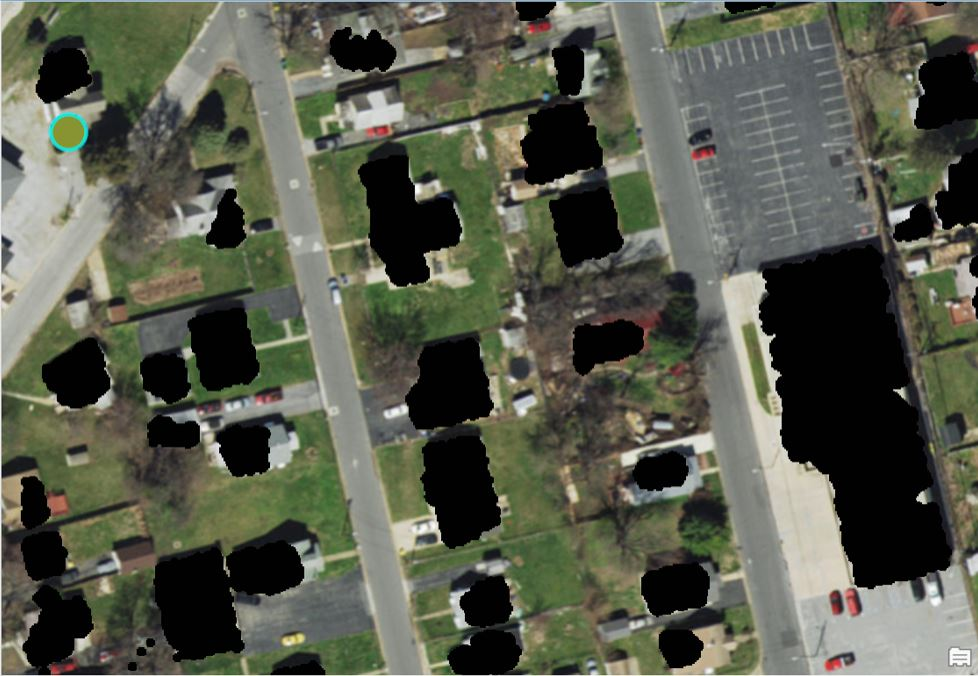
Fig 4. The satellite image with buildings raster overlay, zoomed to one of the selected circle buildings.

### 5.3 Regularize Building Footprint

Here, the arcpy tool `RegularizeBuildingFootprint_3d` will be used for regularizing the buildings, and we would need to go through the workflow three times, for large, medium, and small buildings, separately:

#### 5.3.1 For large-sized buildings

To regularize, eliminate parts, and simply large buildings:

In [ ]:
# Process: Make Feature Layer (10) (Make Feature Layer) 
large_raw_buildings = "LargeRawBuildings"
arcpy.MakeFeatureLayer_management(in_features=input2_2_, 
                                  out_layer=large_raw_buildings, 
                                  where_clause=large_definition, 
                                  workspace="", 
                                  field_info="OBJECTID OBJECTID VISIBLE NONE;Shape Shape VISIBLE NONE;\
                                  Id Id VISIBLE NONE;gridcode gridcode VISIBLE NONE;Shape_Length Shape_Length VISIBLE NONE;\
                                  Shape_Area Shape_Area VISIBLE NONE;POLY_AREA POLY_AREA VISIBLE NONE;\
                                  Type Type VISIBLE NONE;Process Process VISIBLE NONE")

# Process: Calculate Field (10) (Calculate Field) 
large_raw_buildings_3_ = arcpy.CalculateField_management(in_table=large_raw_buildings, 
                                                       field="Type", expression="'Large'", expression_type="PYTHON", 
                                                       code_block="", field_type="LONG")[0]

In [ ]:
# Process: Regularize Building Footprint (9) (Regularize Building Footprint) 
large = fr"{workspace}\Large"
arcpy.RegularizeBuildingFootprint_3d(in_features=large_raw_buildings_3_, 
                                     out_feature_class=large, 
                                     method=large_method, 
                                     tolerance=large_tolerance, 
                                     densification=large_densification, 
                                     precision=large_precision, 
                                     diagonal_penalty=large_diagonal_penalty, 
                                     min_radius=0.1, max_radius=1000000)

# Process: Eliminate Polygon Part (Eliminate Polygon Part) 
large_eliminatePolygonPart = fr"{workspace}\Large_EliminatePolygonPart"
arcpy.EliminatePolygonPart_management(in_features=large, 
                                      out_feature_class=large_eliminatePolygonPart, 
                                      condition="AREA", 
                                      part_area="200 SquareFeet", 
                                      part_area_percent=0, 
                                      part_option="CONTAINED_ONLY")

# Process: Simplify Building (Simplify Building) 
large_simplifyBuildingSB2 = fr"{workspace}\Large_SimplifyBuildingSB2"
arcpy.SimplifyBuilding_cartography(in_features=large_eliminatePolygonPart, 
                                   out_feature_class=large_simplifyBuildingSB2, 
                                   simplification_tolerance="2 Feet", 
                                   minimum_area="0 SquareMeters", 
                                   conflict_option="NO_CHECK", in_barriers=[])

# Process: Calculate Field (2) (Calculate Field) 
large_simplifyBuildingSB2_2_ = arcpy.CalculateField_management(in_table=large_simplifyBuildingSB2, 
                                                               field="Process", expression="!BLD_STATUS!", 
                                                               expression_type="PYTHON", code_block="", 
                                                               field_type="LONG")[0]

#### 5.3.2  For the medium-sized buildings

Then applying the same workflow to regularize, eliminate parts, and simply medium buildings:

In [ ]:
# Process: Make Feature Layer (11) (Make Feature Layer) 
medium_raw_buildings = "MediumRawBuildings"
arcpy.MakeFeatureLayer_management(in_features=input2_2_, 
                                  out_layer=medium_raw_buildings, 
                                  where_clause=medium_definition, 
                                  workspace="", 
                                  field_info="OBJECTID OBJECTID VISIBLE NONE;Shape Shape VISIBLE NONE;\
                                  Id Id VISIBLE NONE;gridcode gridcode VISIBLE NONE;Shape_Length Shape_Length VISIBLE NONE;\
                                  Shape_Area Shape_Area VISIBLE NONE;POLY_AREA POLY_AREA VISIBLE NONE;\
                                  Type Type VISIBLE NONE;Process Process VISIBLE NONE")

# Process: Calculate Field (11) (Calculate Field) 
medium_raw_buildings_3_ = arcpy.CalculateField_management(in_table=medium_raw_buildings, 
                                                          field="Type", expression="'Medium'", 
                                                          expression_type="PYTHON", code_block="", 
                                                          field_type="LONG")[0]

In [ ]:
# Process: Regularize Building Footprint (10) (Regularize Building Footprint) 
medium = fr"{workspace}\Medium"
if large_simplifyBuilding_SB8_2_:
    arcpy.RegularizeBuildingFootprint_3d(in_features=medium_raw_buildings_3_, 
                                         out_feature_class=medium, 
                                         method="RIGHT_ANGLES_AND_DIAGONALS", 
                                         tolerance=medium_tolerance, 
                                         densification=medium_densification, 
                                         precision=medium_precision, 
                                         diagonal_penalty=medium_diagonal_penalty, 
                                         min_radius=0.1, max_radius=1000000)

# Process: Eliminate Polygon Part (2) (Eliminate Polygon Part) 
medium_eliminatePolygonPart = fr"{workspace}\Medium_EliminatePolygonPart"
if large_simplifyBuilding_SB8_2_:
    arcpy.EliminatePolygonPart_management(in_features=medium, 
                                          out_feature_class=medium_eliminatePolygonPart, 
                                          condition="AREA", 
                                          part_area="150 SquareFeet", 
                                          part_area_percent=0, 
                                          part_option="CONTAINED_ONLY")

# Process: Simplify Building (5) (Simplify Building) 
medium_simplifyBuildingSB2 = fr"{workspace}\Medium_SimplifyBuildingSB2"
if large_simplifyBuilding_SB8_2_:
    arcpy.SimplifyBuilding_cartography(in_features=medium_eliminatePolygonPart, 
                                       out_feature_class=medium_simplifyBuildingSB2, 
                                       simplification_tolerance="2 Feet", 
                                       minimum_area="0 SquareMeters", 
                                       conflict_option="NO_CHECK", in_barriers=[])

# Process: Calculate Field (6) (Calculate Field) 
if large_simplifyBuilding_SB8_2_:
    medium_simplifyBuildingSB2_3_ = arcpy.CalculateField_management(in_table=medium_simplifyBuildingSB2, 
                                                                    field="Process", expression="!BLD_STATUS!", 
                                                                    expression_type="PYTHON", code_block="", 
                                                                    field_type="LONG")[0]

#### 5.3.3 For the small-sized buildings

Last but not least, using the same workflow to regularize, eliminate parts, and simply small-sized buildings:

In [ ]:
# Process: Make Feature Layer (12) (Make Feature Layer) 
small_raw_buildings = "SmallRawBuildings"
arcpy.MakeFeatureLayer_management(in_features=input2_2_, 
                                  out_layer=small_raw_buildings, 
                                  where_clause=small_definition, 
                                  workspace="", 
                                  field_info="OBJECTID OBJECTID VISIBLE NONE;Shape Shape VISIBLE NONE;\
                                  Id Id VISIBLE NONE;gridcode gridcode VISIBLE NONE;Shape_Length Shape_Length VISIBLE NONE;\
                                  Shape_Area Shape_Area VISIBLE NONE;POLY_AREA POLY_AREA VISIBLE NONE;\
                                  Type Type VISIBLE NONE;Process Process VISIBLE NONE")

# Process: Calculate Field (12) (Calculate Field) 
small_raw_buildings_3_ = arcpy.CalculateField_management(in_table=small_raw_buildings, 
                                                         field="Type", expression="'Small'", 
                                                         expression_type="PYTHON", code_block="", 
                                                         field_type="LONG")[0]

In [ ]:
# Process: Regularize Building Footprint (11) (Regularize Building Footprint) 
small = fr"{workspace}\Small"
arcpy.RegularizeBuildingFootprint_3d(in_features=small_raw_buildings_3_, 
                                     out_feature_class=small, 
                                     method=smalll_method, 
                                     tolerance=small_tolerance, 
                                     densification=small_densification, 
                                     precision=small_precision, 
                                     diagonal_penalty=small_diagonal_penalty, 
                                     min_radius=0.1, max_radius=1000000)

# Process: Eliminate Polygon Part (3) (Eliminate Polygon Part) 
small_eliminatePolygonPart = fr"{workspace}\Small_EliminatePolygonPart"
arcpy.EliminatePolygonPart_management(in_features=small, 
                                      out_feature_class=small_eliminatePolygonPart, 
                                      condition="AREA", part_area="50 SquareFeet", 
                                      part_area_percent=0, part_option="CONTAINED_ONLY")

# Process: Simplify Building (8) (Simplify Building) 
small_simplifyBuildingSB2 = fr"{workspace}\Small_SimplifyBuildingSB2"
arcpy.SimplifyBuilding_cartography(in_features=small_eliminatePolygonPart, 
                                   out_feature_class=small_simplifyBuildingSB2, 
                                   simplification_tolerance="2 Feet", 
                                   minimum_area="0 SquareMeters", 
                                   conflict_option="NO_CHECK", in_barriers=[])

# Process: Calculate Field (8) (Calculate Field) 
small_simplifyBuildingSB2_2_ = arcpy.CalculateField_management(in_table=small_simplifyBuildingSB2, 
                                                               field="Process", expression="!BLD_STATUS!", 
                                                               expression_type="PYTHON", code_block="", 
                                                               field_type="LONG")[0]

Then, just to merge all these outputs:

In [ ]:
output_2_ = fr"{gdb_location}\Buildings"
if large_simplifyBuilding_SB8_2_:
    with arcpy.EnvManager(extent="MAXOF"):
        arcpy.Merge_management(inputs=[large_simplifyBuilding_SB8_2_, 
                                       medium_simplifyBuilding_SB4_2_, 
                                       small_simplifyBuilding_SB2_2_], 
                               output=output_2_)

With the newly merged buildings footprint overlayed on top of the satellite image, the map would show as the figure below.

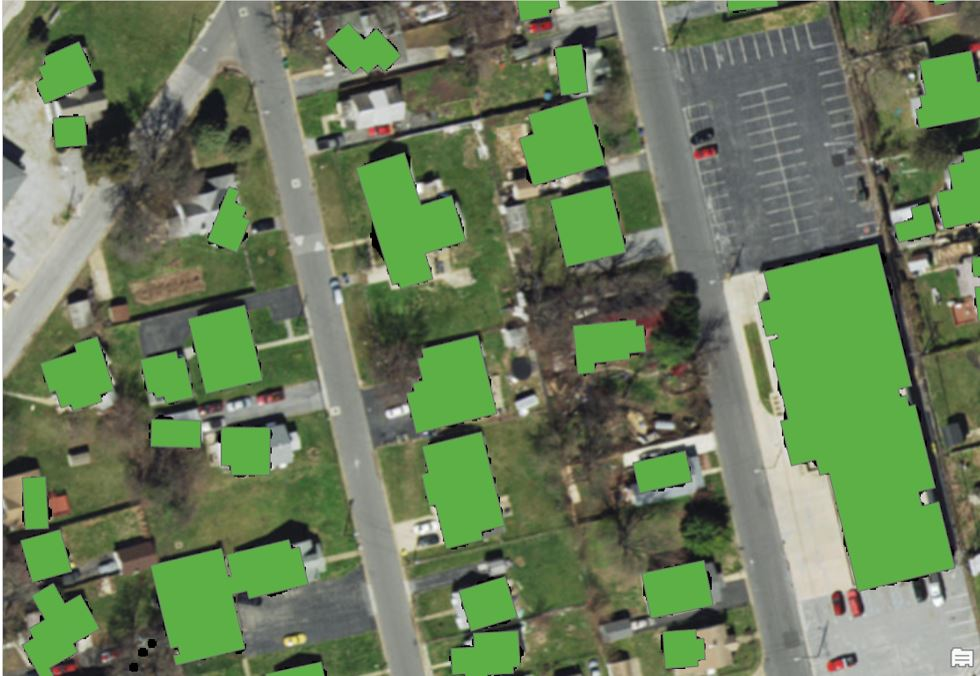
Fig 5. Satellite image, with the regularized buildings footprint.

### 5.4 Generalize Buildings

Building boundaries at detailed levels are mostly not needed for day-to-day productions, because storing and processing complicated geometries is highly time-, and resources-consuming, and also error-prone. Again, the arcpy tool `RegularizeBuildingFootprint_3d` can be used to create a generalized and regularized buildings polygon in this case.

In [ ]:
# Process: Regularize Building Footprint (12) (Regularize Building Footprint) 
buildings_9_ = output_2_
building_generalized = fr"{gdb_location}\Building_generalized"
if large_simplifyBuilding_SB8_2_:
    with arcpy.EnvManager(extent="DEFAULT"):
        arcpy.RegularizeBuildingFootprint_3d(in_features=buildings_9_, 
                                             out_feature_class=building_generalized, 
                                             method="RIGHT_ANGLES_AND_DIAGONALS", 
                                             tolerance=3, densification=1.5, 
                                             precision=0.25, diagonal_penalty=1.5, 
                                             min_radius=0.1, max_radius=1000000)

If the generalized buildings being added to map view, zoomed into smaller area of extent, and compared with the regularized buildings (before simplification), the map looks like Fig 6.

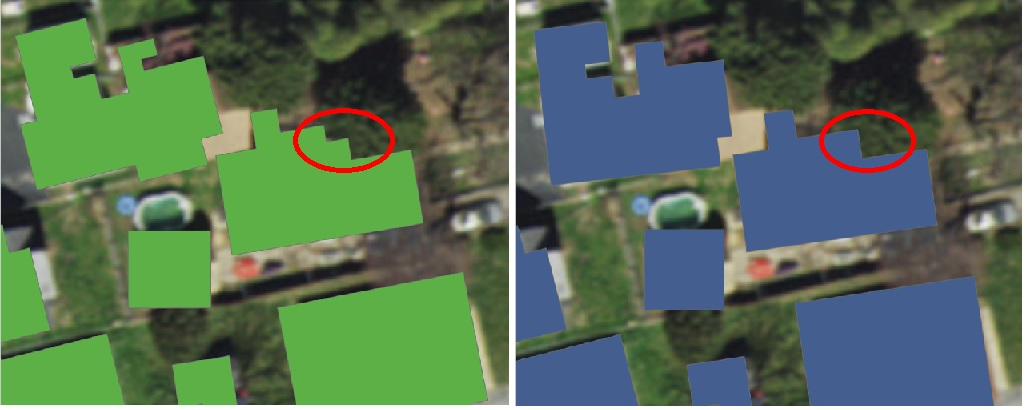
Fig 6. Building footprint before simplification (Left) V.S. the generalized building footprint.

### 5.5 Validation

Now that the process is completed for extracting building footprints from LiDAR, it is critical to examine the results and check for accuracy. We can show the generalized buildings along with the raster data sources, and visually compare in these three manners:
  - Building raster (before smoothing) V.S. Generalized building (vector)
  - The `Imagery` basemap V.S. Generalized building (vector)
  - The original LiDAR point clouds VS. Generalized building (vector)

#### 5.5.1 Building raster V.S. Generalized building

Here, we will compare the mosaic dataset buildings (BuildingRaster) to the generalized buildings layer (Building_generalized). In order to emphasize on the contrast, the symbology of the generalized buildings is set to red outlines and no color fills.

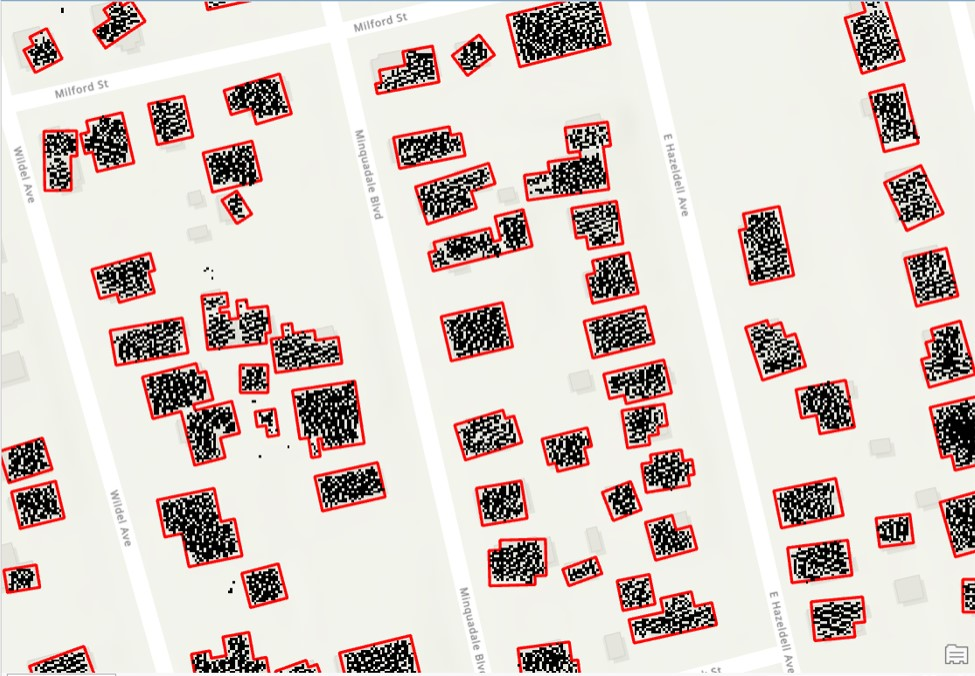
Fig 7. Building raster (before smoothing) V.S. Generalized building (vector)

#### 5.5.2 Imagery basemap V.S. Generalized building

Now, let's compare the building footprints to the basemap that comes with the imagery service. Again, the buildings (vector) layer is symbolized as red outlines and no fillings.

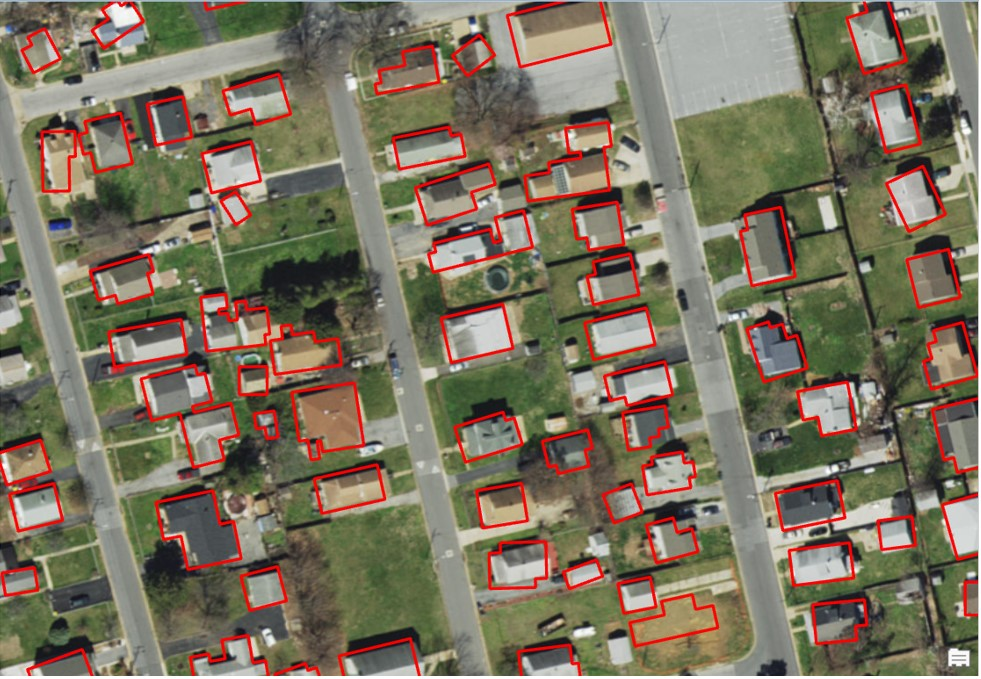
Fig 8. The Imagery basemap V.S. Generalized building (vector)

#### 5.5.3 Original LiDAR point clouds V.S. Generalized building

Thirdly, we can also compare the generalized results to the original LiDAR point clouds classified as buildings.

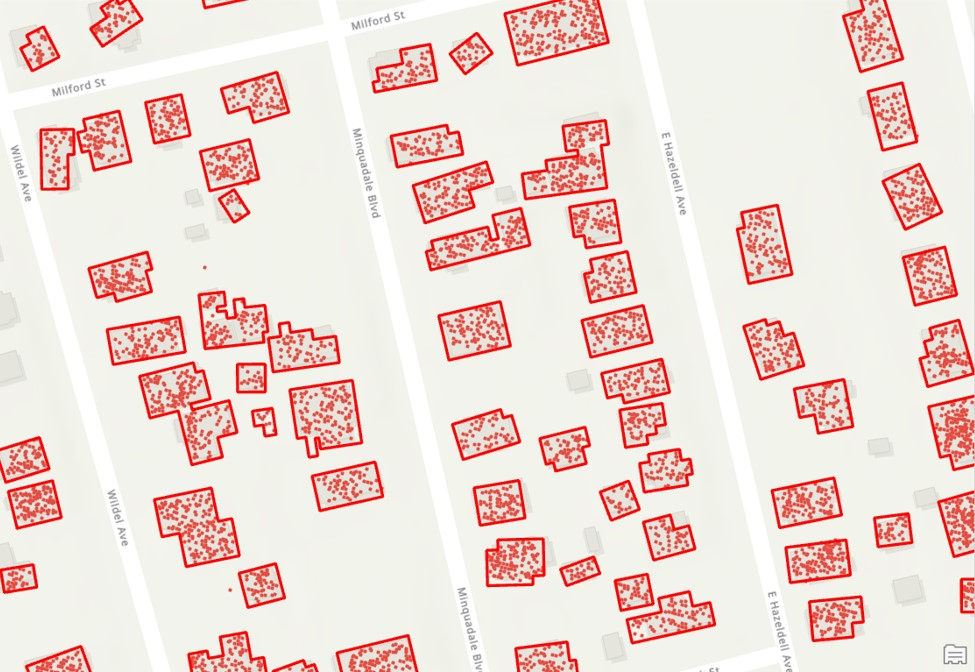
Fig 9. The original LiDAR point clouds VS. Generalized building (vector)

These three comparisons should give you a general sense of how successful your building footprint extraction from classified LiDAR was.

## Conclusions

This notebook demonstrates a common workflow in extracting buildings from classified LiDAR data. The procedures being introduced here include, (1) converting LiDAR to raster, (2) create Mosaic Dataset from the tiled rasters, (3) perform multi-leveled smoothing using a customized tool that replaces Raster Function Template being applied in the Mosaic Dataset, (4) extracting Draft Building Footprint Polygons, and (5) regularizing Draft Building Footprint Polygons. In the last step, divide-and-conquer mechanism has been used to achieve better efficiency and higher accuracy, by splitting the problem set into large, medium, and small-sized buildings. Last but not least, performing validation of the final extracted results is critical in achieving higher accuracy and in the same time avoiding overfitting.

Next in the series, we will discuss how to extract buildings from LiDAR point clouds without classification information. Please stay with us, and continue with the adventures in <a href="./lidar_extract_bldgs_unclassfied_part6.ipynb">Part 6</a>.

## References

[1] "Raster to polygon", https://pro.arcgis.com/en/pro-app/tool-reference/conversion/raster-to-polygon.htm

[2] "Regularize building footprint", https://desktop.arcgis.com/en/arcmap/10.4/tools/3d-analyst-toolbox/regularize-building-footprint.htm

<a href="#Guides-to-LiDAR-(Part-5---Extract-building-footprints-from-classified-LiDAR)">Back to Top</a>